## Background & Objective

Rasio kredit bermaslah di Indoensia cukup tinggi yaitu di angka +/- 3% selama 5 tahun terakhir. Hal tersebut sangat mengganggu cash flow dari bisnis keuangan/perbangkan karena nominal yang tidak dibayar akan sangat besar jika dibandingkan bunga yang diterima dari kredit lancar. Oleh karena itu perlu adanya analisa kredit risk untuk melihat apakah kredit yang diberikan akan bermasalah atau tidak di kemudian hari. 
Dalam kesempatan ini saya mencoba membuat prediksi status resiko dari kredit menggunakan data kredit pelanggan. Output dari project ini adalah machine learning yang mampu memprediksi apakah kredit pelanggan berisiko buruk/bagus kedepannya, sehingga pihak bank ketika pemberian kredit akan lebih tepat berdasarkan prediksi ini 

## Importing Libraries

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn import metrics
from imblearn import under_sampling, over_sampling
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
np.random.seed(0)
pd.set_option('display.max_columns', 22)

## Load dataset & Preliminary Look

In [94]:
# Load dataset
df = pd.read_csv('credit_customers.csv')

In [3]:
# view dataset
print(df.shape)
df.head()

(1000, 21)


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [4]:
# General information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [5]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

**Data dictionary**

* checking_status: Status of existing checking account
* duration: Duration in months
* credit_history: credits taken, paid back duly, delays, critical accounts
* purpose: Purpose of the credit
* credit_amount: Amount of credit
* savings_status: Status of savings account/bond
* employment: Present employment, in number of years
* installment_commitment: Installment rate in percentage of disposable income
* personal_status: sex and marital data
* other_parties: Other debtors / guarantors
* residence_since: residence_since
* property_magnitude: property_magnitude
* age: age
* other_payment_plans:
* housing:
* existing_credits:
* job:
* num_dependents:
* own_telephone:
* foreign_worker:
* class:

# Exploratory Data Analysis

In [6]:
#check missing ratio
data_na = (df.isnull().sum() / len(df)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)

,Missing Ratio


In [7]:
# duplicated rows check
duplicate_rows_data = df.duplicated().sum()
print(f"number of duplicate rows: {duplicate_rows_data}")

number of duplicate rows: 0


Observation
1. Data mengandung 1000 baris dan 21 kolom
2. Tidak ada missing value dan duplicate
3. kolom Class sebagai target

In [8]:
# deviding columns base on type
numericals = df.select_dtypes(include=['int64','float64']).columns.tolist()
categoricals = df.select_dtypes(exclude=['int64','float64']).columns.tolist()

print(f"numericals columns are {numericals}")
print('')
print(f"categoricals columns are {categoricals}")

numericals columns are ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']

categoricals columns are ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']


In [9]:
# stat summary numerical columns
df[numericals].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment_commitment,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


Oservation:

1. Min-max values are mostly making sense
2. Kolom age terlihat simetris, mean ~ median
3. Beberapa kolom discret juga balance, installment_commitment, residence_since, seperti num_dependents

In [10]:
# stat summary categoricals columns
df[categoricals].describe().T

,count,unique,top,freq
checking_status,1000,4,no checking,394
credit_history,1000,5,existing paid,530
purpose,1000,10,radio/tv,280
savings_status,1000,5,<100,603
employment,1000,5,1<=X<4,339
personal_status,1000,4,male single,548
other_parties,1000,3,none,907
property_magnitude,1000,4,car,332
other_payment_plans,1000,3,none,814
housing,1000,3,own,713


Oservation:

1. Kolom target bernilai binary, begitupun juga kolom own_telephone & foreign_worker
2. Kolom purpose mempunyai unique value tertinggi
3. beberapa kolom mungkin dapat diencoding ordinal

## Univariate & Multivariate Analysis

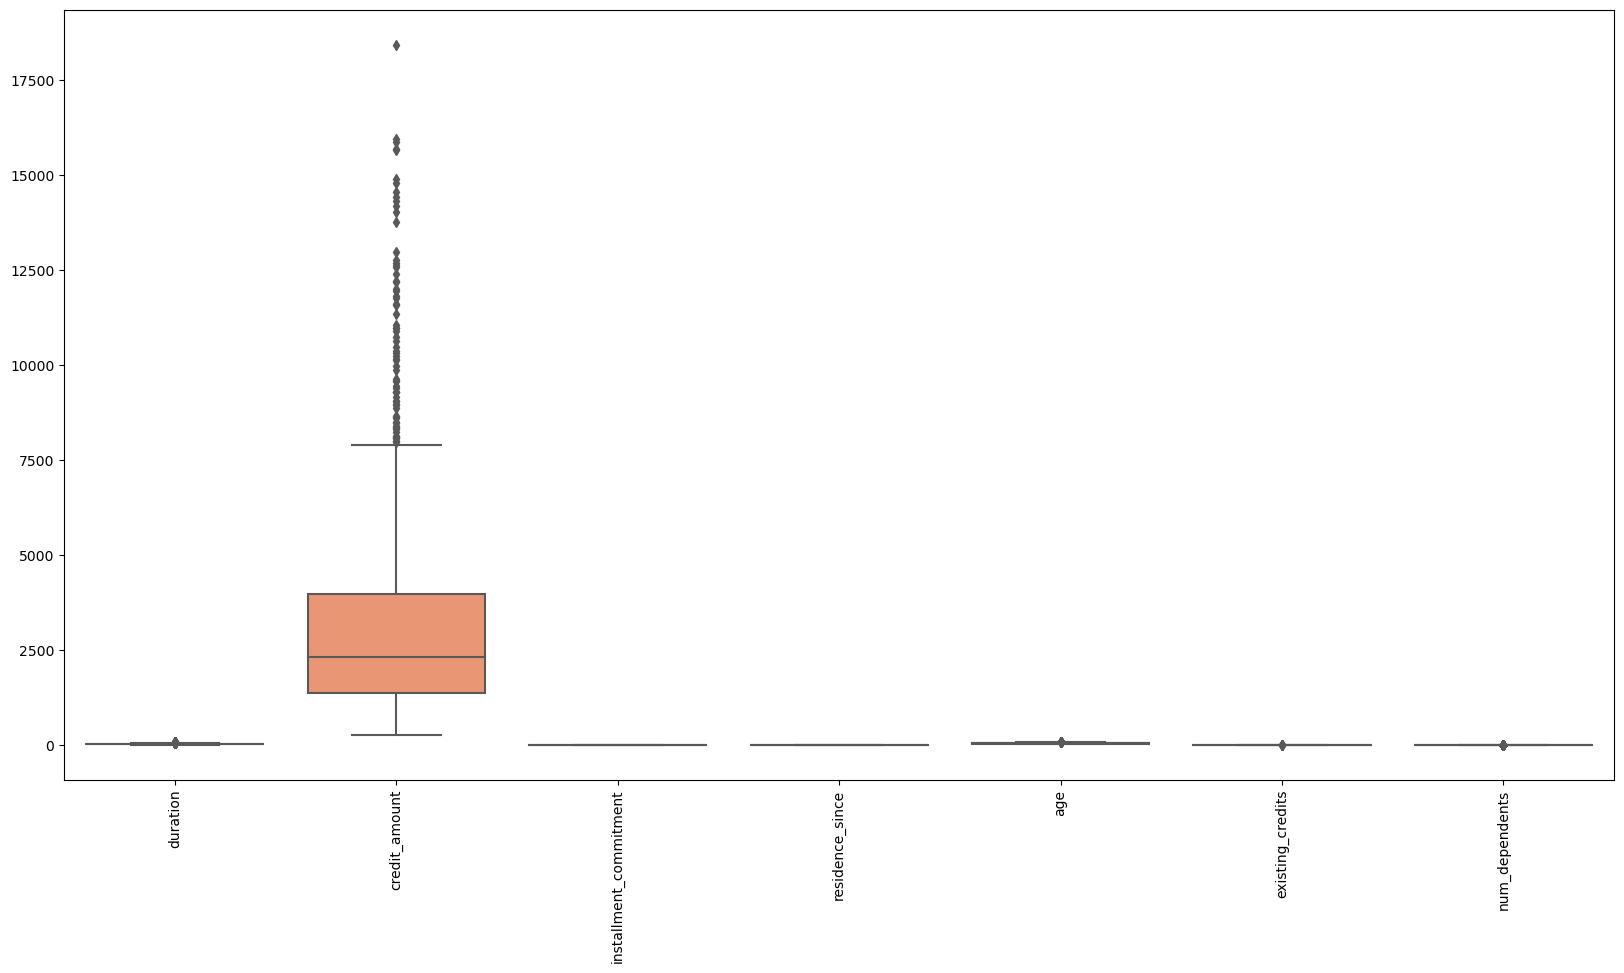

In [11]:
# Outlier checking
plt.figure(figsize=(20,10))
sns.boxplot(data = df,palette = "Set2")
plt.xticks(rotation=90)
plt.show()

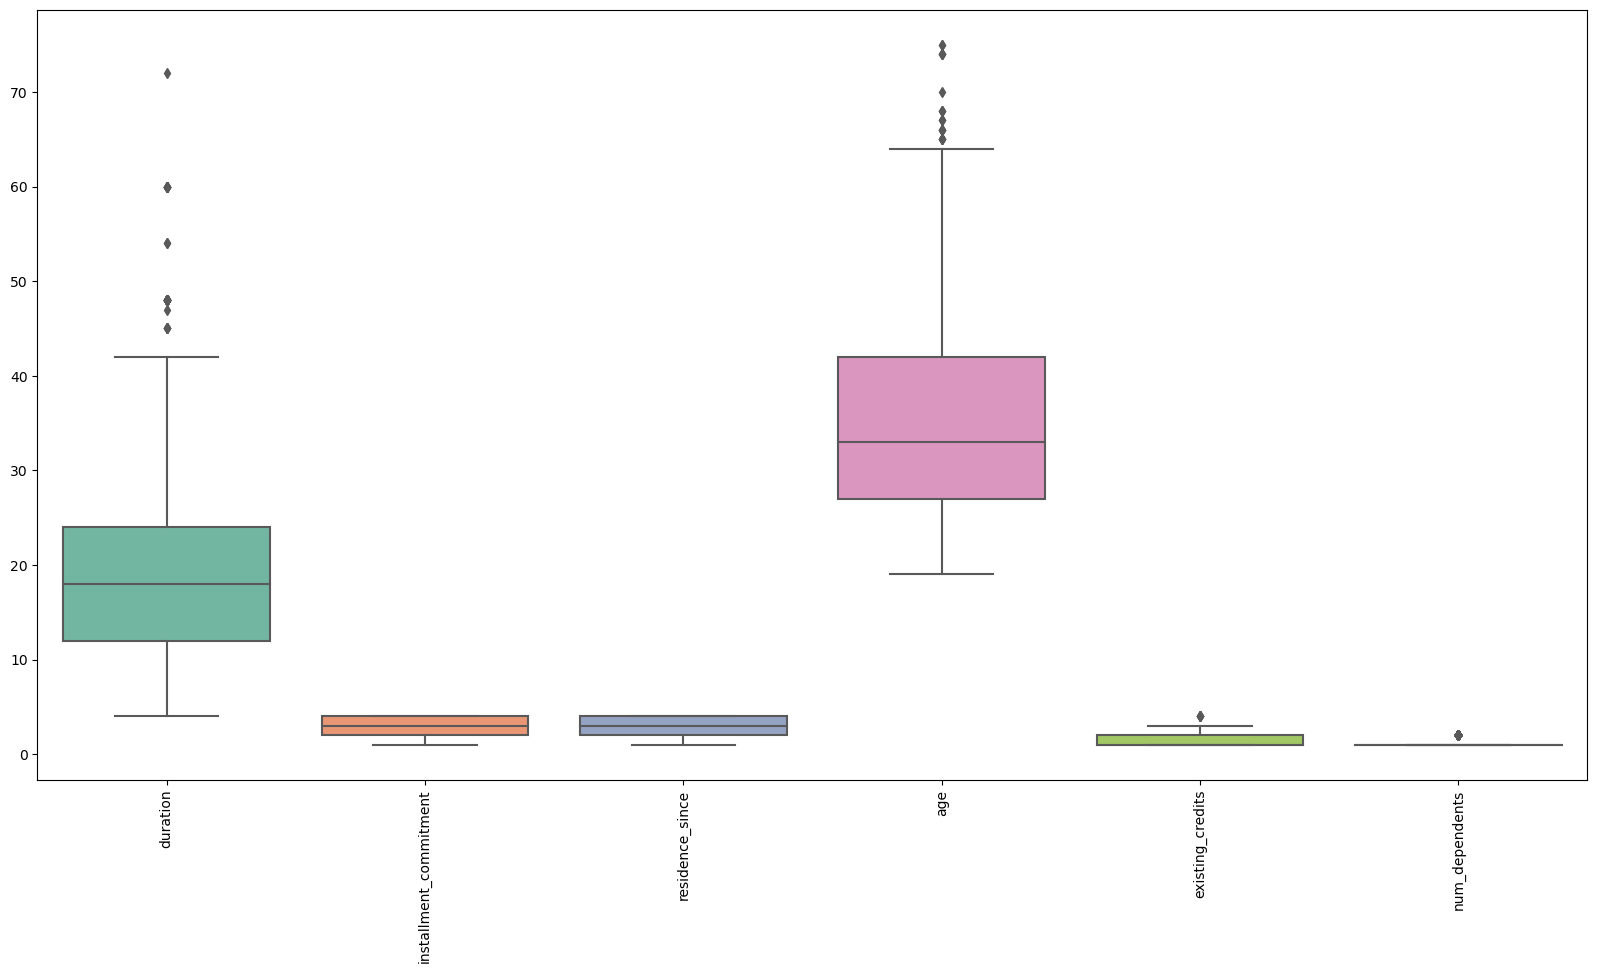

In [12]:
# Outlier checking
plt.figure(figsize=(20,10))
df_bp = df[['duration', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']]
sns.boxplot(data = df_bp,palette = "Set2")
plt.xticks(rotation=90)
plt.show()

Observation

* credit_amount, duration, dan age mempunyai otlier yang cukup banyak, namun karena saya rasa angkanya masih wajar maka saya tidak akan membuang itu
* berdasarkan posisi boxplot rentang tiap kolom berbeda (dapat dilakukan scaling sebelum modeling)

<AxesSubplot:xlabel='class', ylabel='count'>

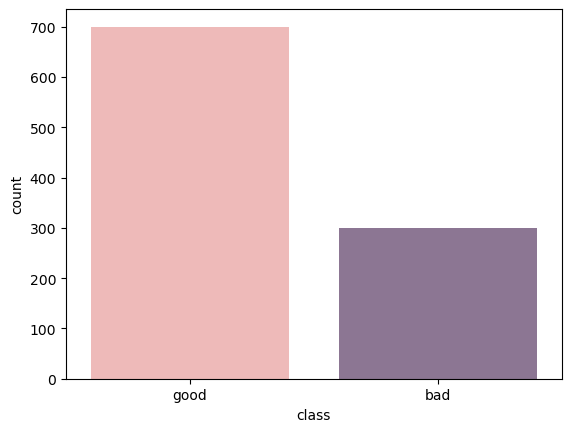

In [13]:
#first of all let us evaluate the target

colours=["#f7b2b0","#8f7198"]
sns.countplot(data= df, x="class",palette=colours)

In [14]:
# Check amount of unique value
df['class'].value_counts()

good    700
bad     300
Name: class, dtype: int64

Mayoritas class credit risk dilabeli good di data ini, sejumlah 700 nasabah

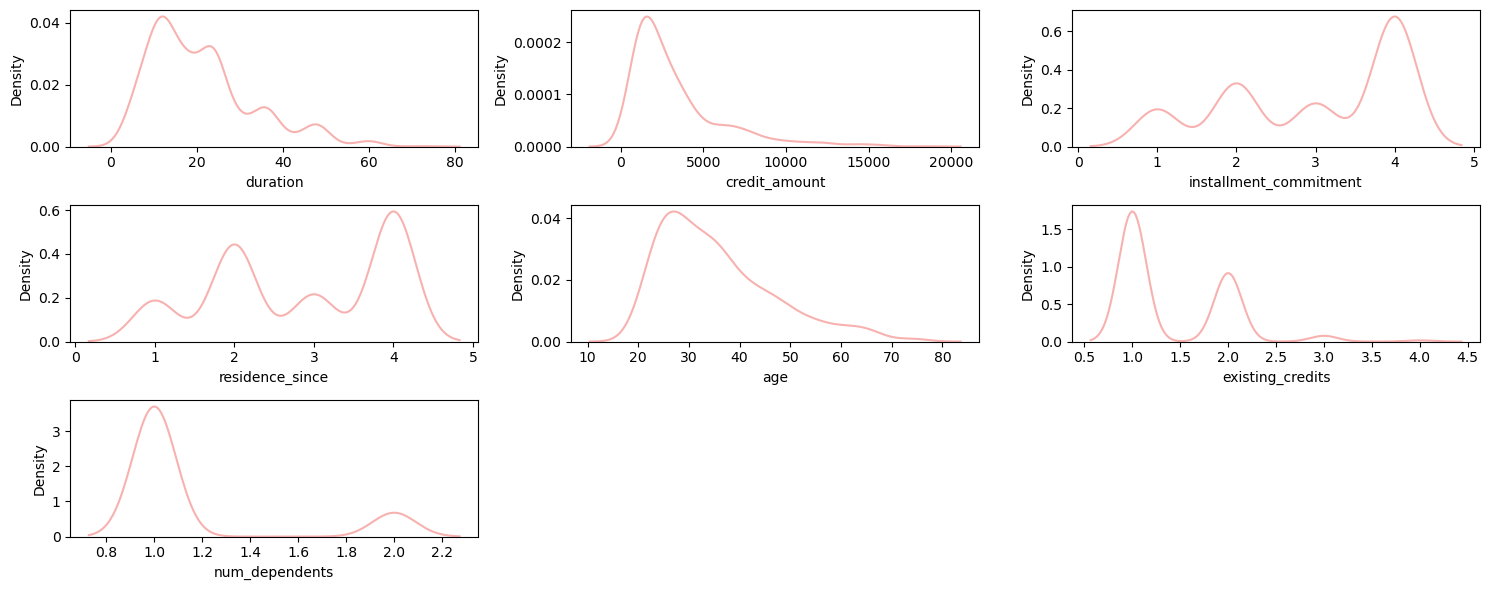

In [15]:
# KDE plot other columns based on fetal_health 
plt.figure(figsize=(15,6))

features = numericals
for i in np.arange(1, len(features)+1):
    plt.subplot(3, len(features)//3+1, i)
    sns.kdeplot(x=df[features[i-1]], color='#f7b2b0')
    plt.xlabel(features[i-1])
    plt.tight_layout()

* Tidak ada kolom yang benar-benar simetris
* Beberapa kolom bersifat bimodal seperti num_dependents, exsisting_credits, residence_since

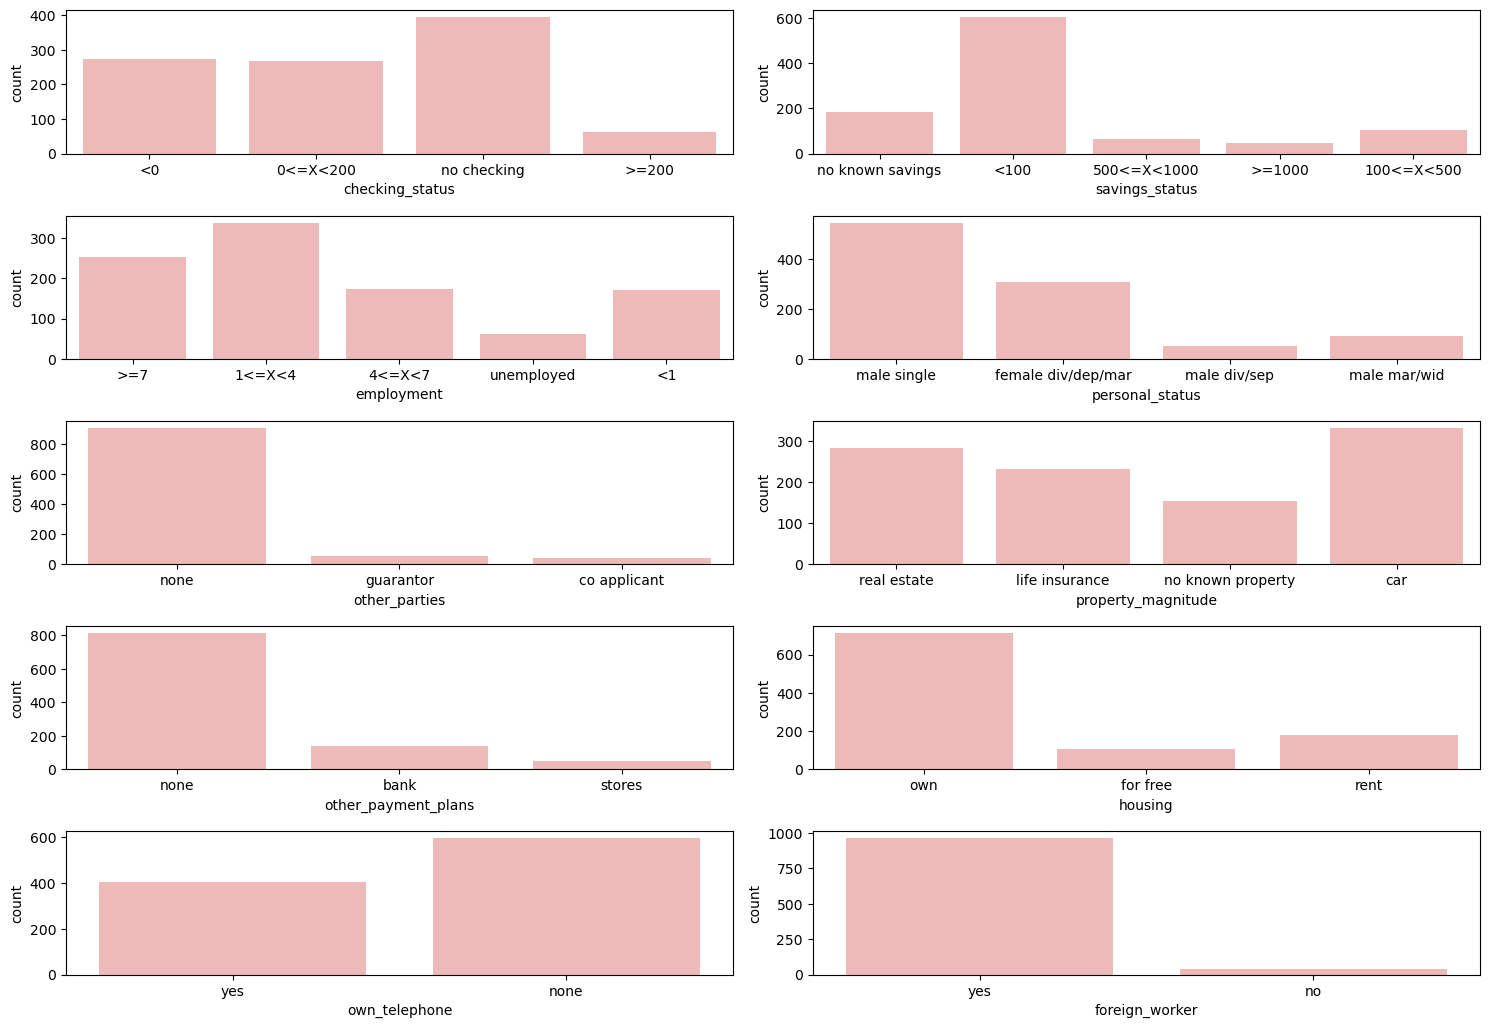

In [96]:
plt.figure(figsize=(15,12))
                         
features_1 = ['checking_status', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'own_telephone', 'foreign_worker']
for i in np.arange(1, len(features_1)+1):
    plt.subplot(6, len(features_1)//6+1, i)
    sns.countplot(x=df[features_1[i-1]], color='#f7b2b0')
    plt.xlabel(features_1[i-1])
    plt.tight_layout()

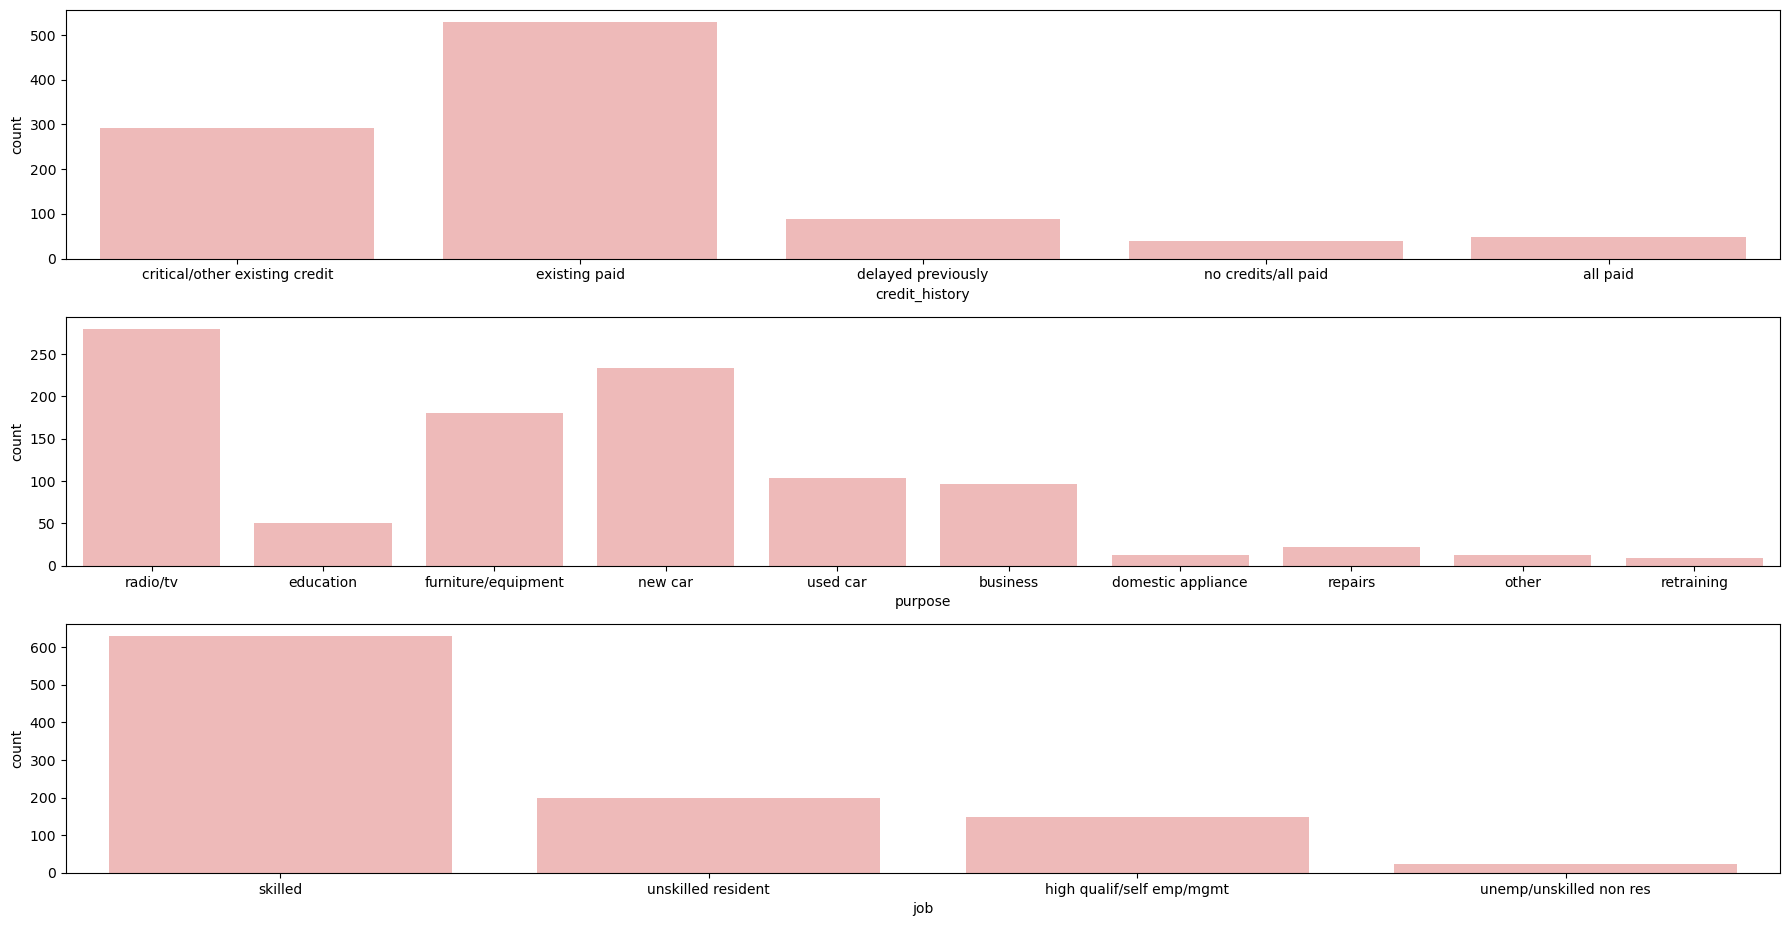

In [97]:
plt.figure(figsize=(18,12))
                         
features_2 = ['credit_history', 'purpose', 'job']
for i in np.arange(1, len(features_2)+1):
    plt.subplot(4, len(features_2)//4+1, i)
    sns.countplot(x=df[features_2[i-1]], color='#f7b2b0')
    plt.xlabel(features_2[i-1])
    plt.tight_layout()

Observation:

- Beberapa kredit diajukan untuk kebutuhan konsumtif
- Karena kebanyakan pelanggan mempunyai credit risk bagus maka job yang dipunyai paling banyak pekerja terampil

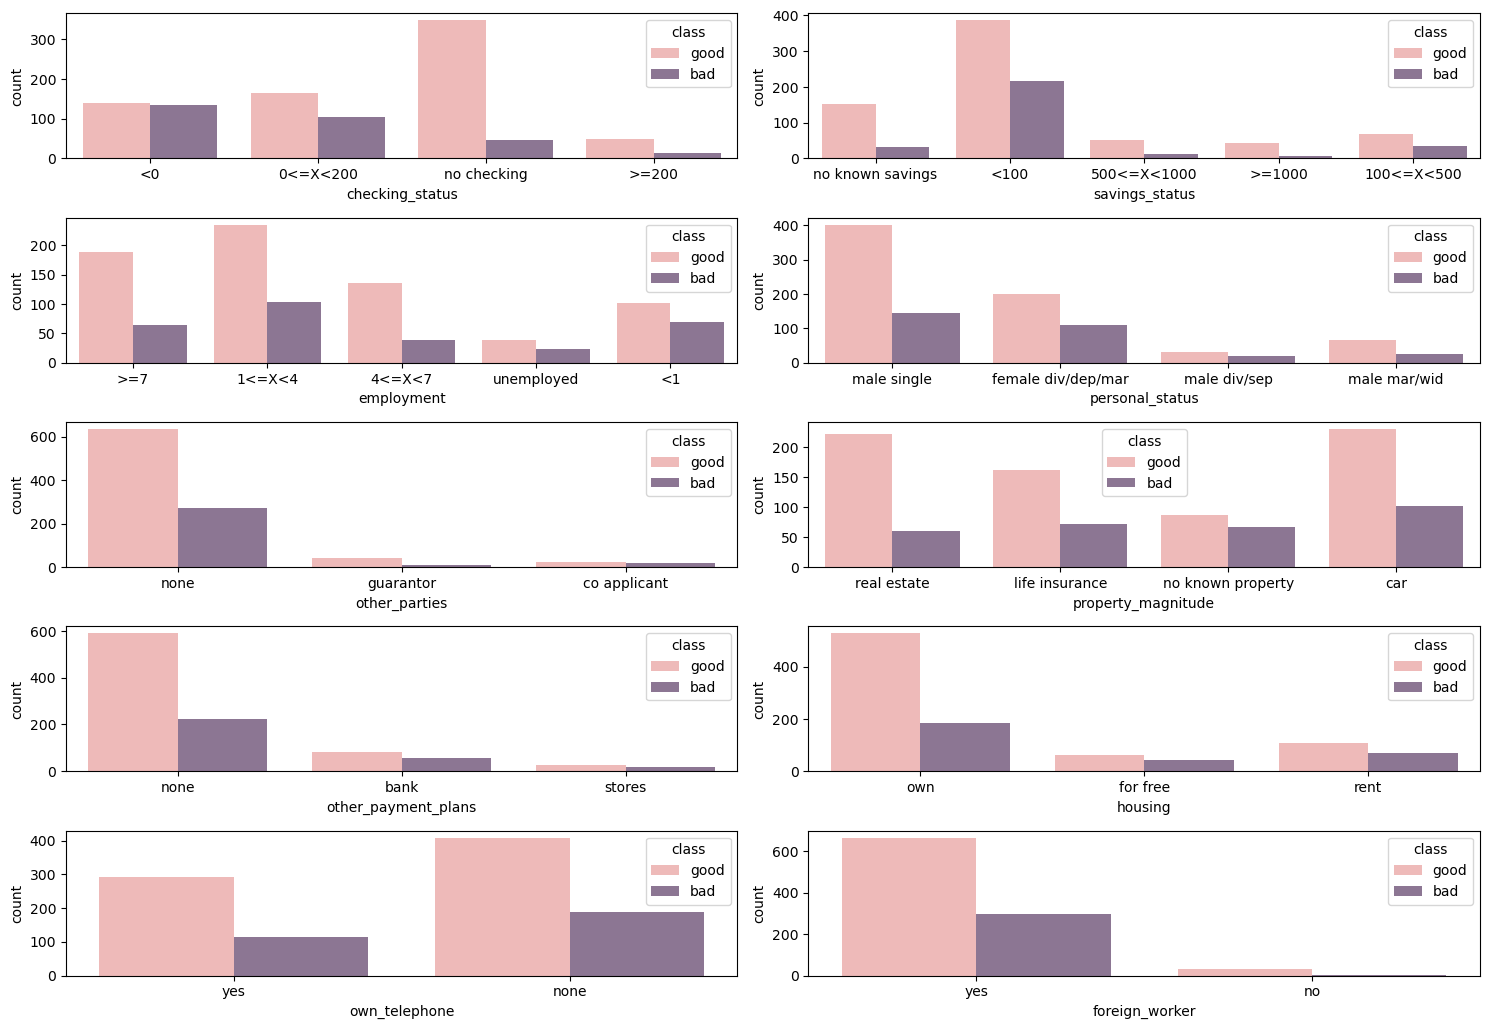

In [16]:
plt.figure(figsize=(15,12))
                         
features_1 = ['checking_status', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'own_telephone', 'foreign_worker']
for i in np.arange(1, len(features_1)+1):
    plt.subplot(6, len(features_1)//6+1, i)
    sns.countplot(x=df[features_1[i-1]], hue=df['class'], palette=colours)
    plt.xlabel(features_1[i-1])
    plt.tight_layout()

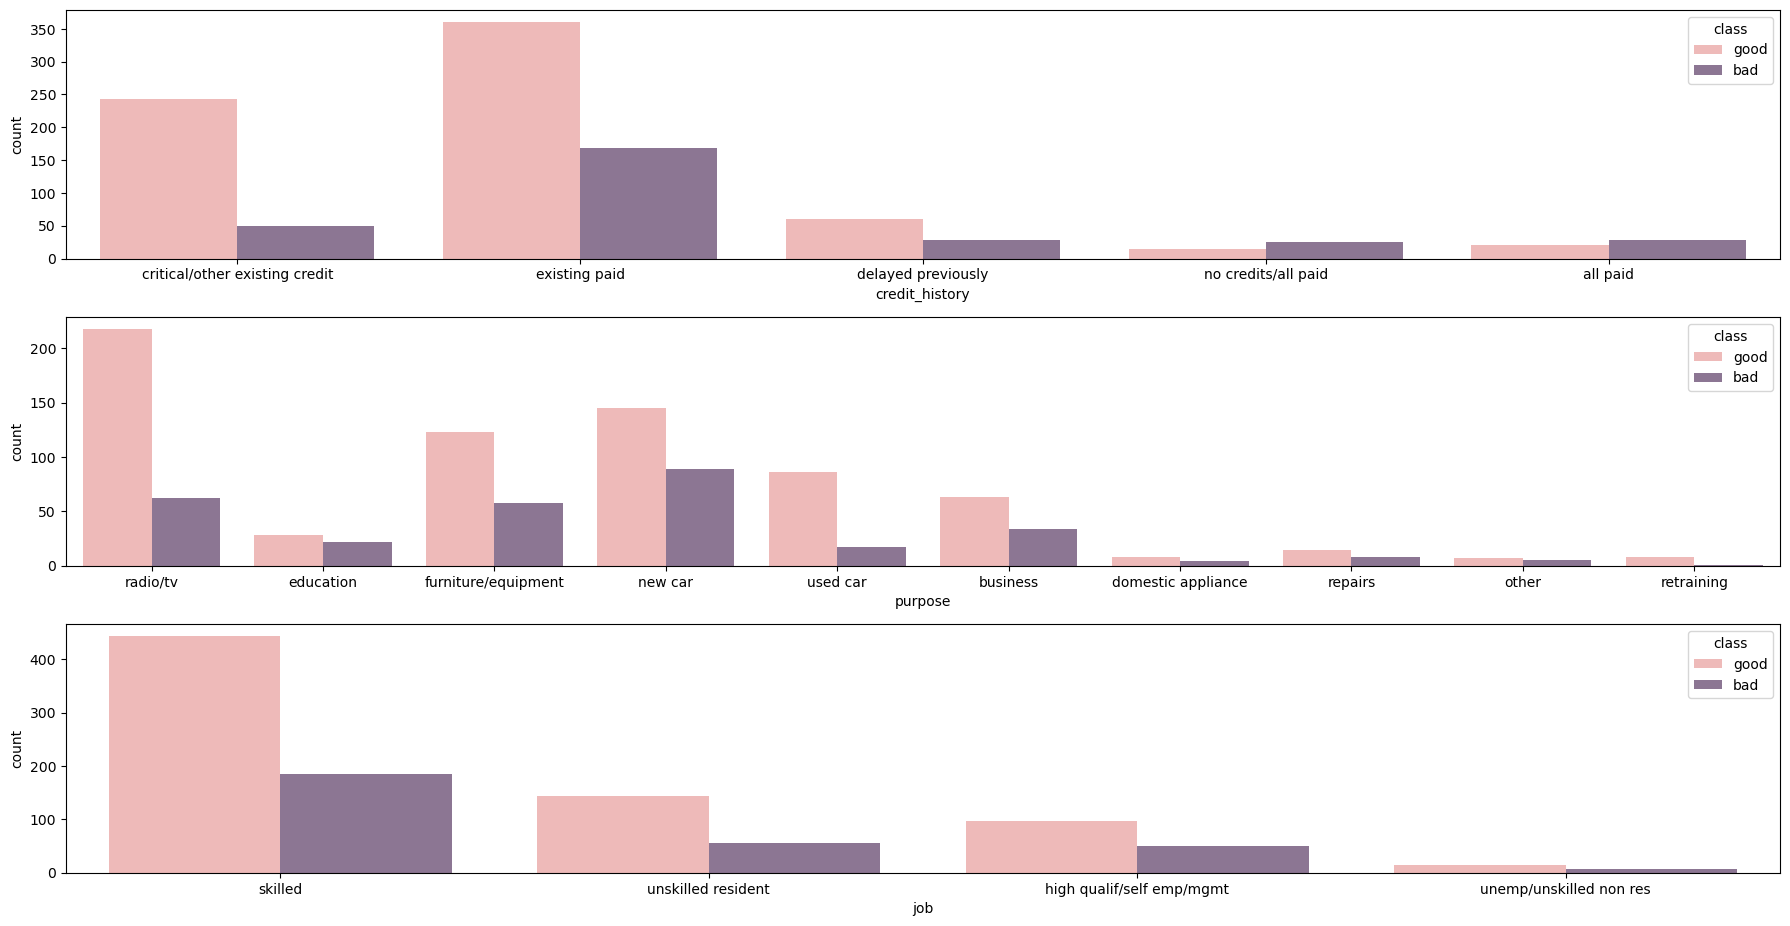

In [17]:
plt.figure(figsize=(18,12))
                         
features_2 = ['credit_history', 'purpose', 'job']
for i in np.arange(1, len(features_2)+1):
    plt.subplot(4, len(features_2)//4+1, i)
    sns.countplot(x=df[features_2[i-1]], hue=df['class'], palette=colours)
    plt.xlabel(features_2[i-1])
    plt.tight_layout()

Observation:

* Pelanggan yang mempunyai status rekening giro kurang dari 0 (checking status) cenderung mempunyai potensi kredit buruk
* Pelanggan yang tidak bekerja cenderung mempunyai potensi kredit buruk
* Pelanggan dengan nilai "gratis" atau "sewa" untuk housing lebih cenderung menjadi pelanggan dengan risiko potensial
* Pelanggan dengan credit history all paid & no credit cenderung berpotensi kredit buruk

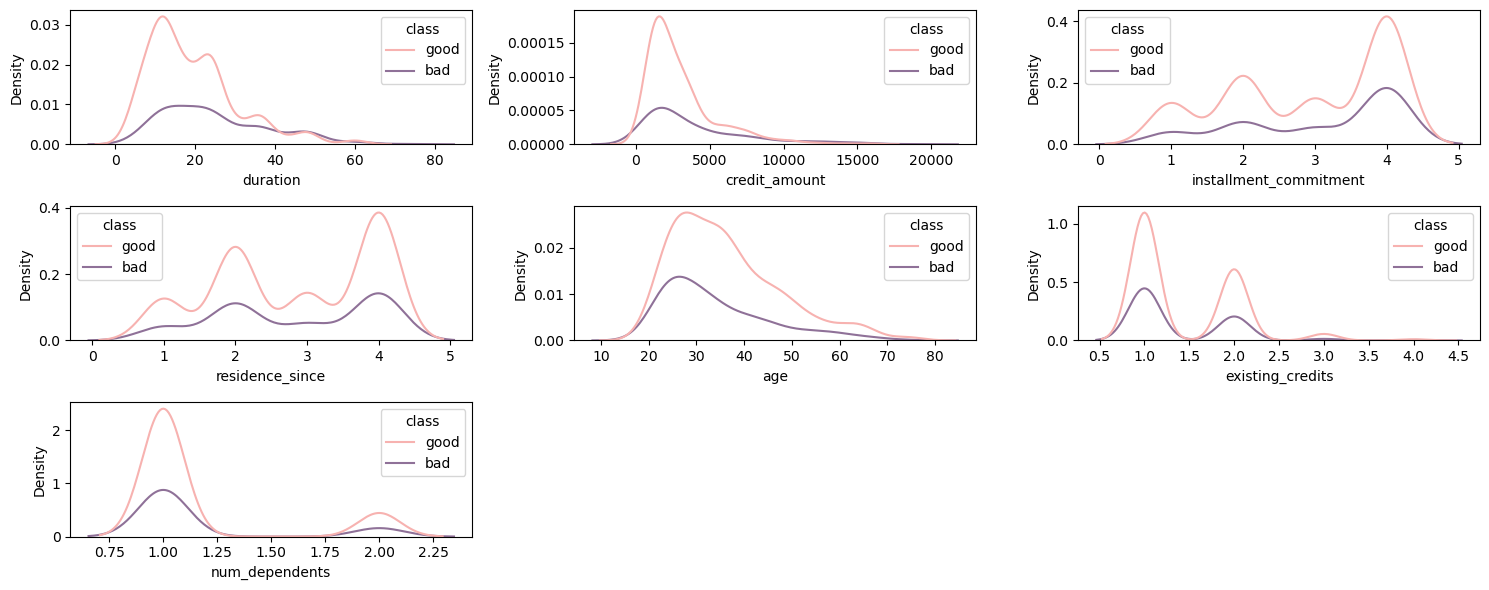

In [18]:
# KDE plot other columns based on fetal_health 
plt.figure(figsize=(15,6))

features = numericals
for i in np.arange(1, len(features)+1):
    plt.subplot(3, len(features)//3+1, i)
    sns.kdeplot(x=df[features[i-1]], hue=df['class'], palette=colours)
    plt.xlabel(features[i-1])
    plt.tight_layout()

Observation:

* Umur yang lebih muda cenderung berisiko terhadap credit
* Durasi credit pelanggan dengan credit risk berisiko cenderung lebih lama

In [19]:
# Ordinal encoding
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()

df['class'] = ord_enc.fit_transform(df[['class']])

<AxesSubplot:>

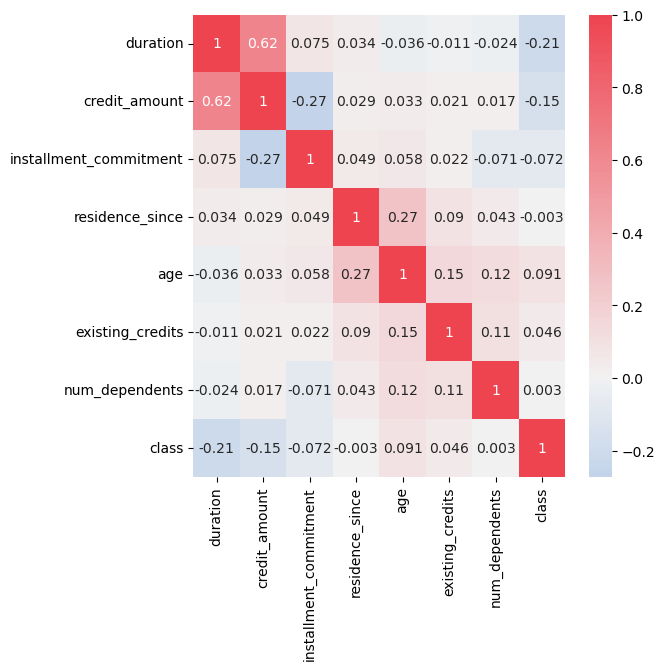

In [20]:
#correlation matrix
corrmat= df.corr()
plt.figure(figsize=(6,6))  

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)

sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

## Deep-dive Analysis

In [21]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,1.0
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,0.0
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,1.0
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,1.0
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,0.0


- pelanggan dengan umur berapa yang mendapatkan jumlah kredit terbanyak dan bagaimana kelasnya?

In [27]:
# groupby age
gb_age = (df
          .groupby(['age'])
          .agg(credit_amount=('credit_amount','sum'))
          .reset_index()).sort_values('credit_amount', ascending=False)
gb_age.head()

,age,credit_amount
8,27.0,172920.0
11,30.0,158675.0
5,24.0,154104.0
7,26.0,146397.0
4,23.0,143681.0


Berikut adalah umur pelanggan yang mendapat total kredit terbanyak yaitu umur 27. Terdapat pelanggan umur 23 dan 24 yang secara pendapatan seharusnya belum terlalu stabil karena baru saja lulus.

In [34]:
# group by age and class base on age having bigger credit amount
list_age= list(gb_age.head()['age'])

gb_age_1 = (df
          .groupby(['age', 'class'])
          .agg(credit_amount=('credit_amount','sum'))
          .reset_index()).sort_values('credit_amount', ascending=False)

filt = gb_age_1['age'].isin(list_age)
gb_age_1.loc[filt]

,age,class,credit_amount
23,30.0,1.0,117702.0
17,27.0,1.0,109455.0
15,26.0,1.0,87506.0
8,23.0,0.0,84080.0
11,24.0,1.0,77977.0
10,24.0,0.0,76127.0
16,27.0,0.0,63465.0
9,23.0,1.0,59601.0
14,26.0,0.0,58891.0
22,30.0,0.0,40973.0


umur 23 tahun dengan kelas bad mendapat jumlah kredit lebih banyak daripada kelas good, ini cukup berisiko karena pendapatan yang kurang stabil

<AxesSubplot:xlabel='employment', ylabel='count'>

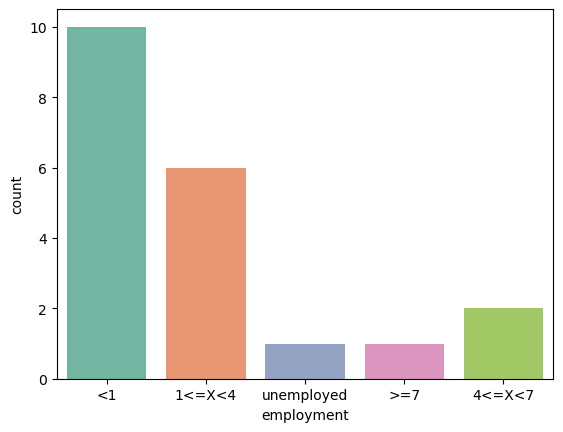

In [51]:
# Check empoloyment status who has age 23 with class bad
set2 = sns.color_palette("Set2")

filt = (df['age'] == 23) & (df['class'] == 0.0)
df_filt = df.loc[filt]

sns.countplot(data= df_filt, x="employment", palette=set2)

Dengan durasi kerja yang cukup rendah dan bank memberikan jumlah kredit yang cukup besar ini cukup berisiko dan perlu dipertimbangkan untuk kedepannya

## Modeling

### 1. Model Baseline

<AxesSubplot:xlabel='class', ylabel='count'>

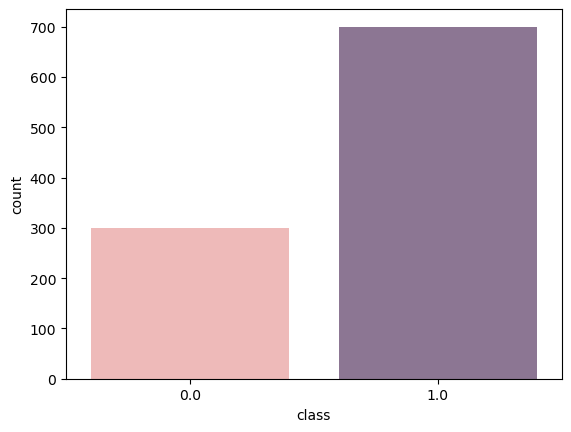

In [52]:
#first of all let us evaluate the target

colours=["#f7b2b0","#8f7198"]
sns.countplot(data= df, x="class",palette=colours)

- 0.0 adalah kelas berisiko(bad)
- 1.0 adalah kelas good
- Imbalance data target

In [53]:
# Encoding features
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()

df['checking_status'] = ord_enc.fit_transform(df[['checking_status']])
df['credit_history'] = ord_enc.fit_transform(df[['credit_history']])
df['purpose'] = ord_enc.fit_transform(df[['purpose']])
df['savings_status'] = ord_enc.fit_transform(df[['savings_status']])
df['employment'] = ord_enc.fit_transform(df[['employment']])
df['personal_status'] = ord_enc.fit_transform(df[['personal_status']])
df['other_parties'] = ord_enc.fit_transform(df[['other_parties']])
df['property_magnitude'] = ord_enc.fit_transform(df[['property_magnitude']])
df['other_payment_plans'] = ord_enc.fit_transform(df[['other_payment_plans']])
df['housing'] = ord_enc.fit_transform(df[['housing']])
df['job'] = ord_enc.fit_transform(df[['job']])
df['own_telephone'] = ord_enc.fit_transform(df[['own_telephone']])
df['foreign_worker'] = ord_enc.fit_transform(df[['foreign_worker']])

In [54]:
# spliting features and target
X=df.drop(["class"],axis=1)
y=df["class"]

In [55]:
#spliting test and training sets
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Saya menggunakan 3 model ensemble yaitu adaboost, lightgbm, dan xgboost

In [56]:
list_model = [AdaBoostClassifier(random_state=42),
              LGBMClassifier(random_state=42),
              XGBClassifier(random_state=42)
]

df_eval1 = pd.DataFrame(columns = ['Methods','precison train', 'precision test'])

for model in list_model:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    method = str(type(model)).split('.')[-1][:-2]
    
    #recall
    prec_train = precision_score(y_train, y_pred_train)
    prec_test = precision_score(y_test, y_pred_test)
    
    df_eval1 = df_eval1.append({'Methods': method, 'precison train':prec_train, 'precision test':prec_test}, ignore_index=True)
    
df_eval1

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1404\2711708608.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_eval1 = df_eval1.append({'Methods': method, 'precison train':prec_train, 'precision test':prec_test}, ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1404\2711708608.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_eval1 = df_eval1.append({'Methods': method, 'precison train':prec_train, 'precision test':prec_test}, ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1404\2711708608.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_eval1 = df_eval1.append({'Methods': method, 'precison train':prec_train, 'precision test':prec_test}, ignore_index=True)


,Methods,precison train,precision test
0,AdaBoostClassifier,0.817152,0.794872
1,LGBMClassifier,1.000000,0.830065
2,XGBClassifier,1.000000,0.855263


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


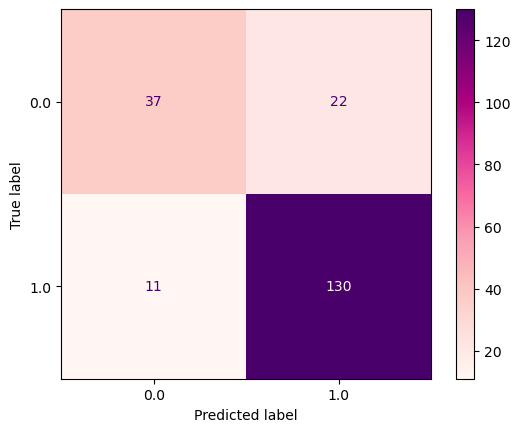

Prescision score:  0.8552631578947368


In [57]:
# plotting confusion matrix
from sklearn.metrics import plot_confusion_matrix

# instantiating and fitting decision tree model
xgb_clf = XGBClassifier(random_state=42) 
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

plot_confusion_matrix(xgb_clf, X_test, y_test,cmap="RdPu")
plt.show()
print('Prescision score: ',precision_score(y_test, y_pred))

Observations:

**0: Bad**
**1: Good**

- False Positive: Prediksi menunjukkan hasil good padahal actual bad
- False Negative: Prediksi menunjukkan hasil bad padahal actual good


* Dalam case ini saya ingin menminimalkan hasil false positive oleh karena itu fokus scoring menggunakan Presisi
* Model XGBoost mendapatkan nilai yang cukup baik untuk baseline model dengan niali presisi 85.52%
* Nilai itu berarti dari 100 pelanggan yang diprediksi credit risknya good, 85 diantaranya actual credit scorenya good
* Saya akan melakukan tuning parameter manual untuk mendapatkan performa yang lebih baik

## 2. Modeling with Hyperparameter

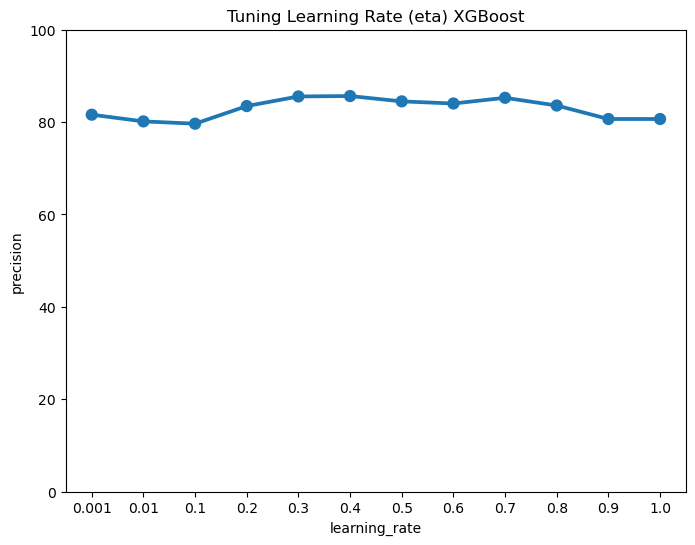

In [70]:
learning_rate_list = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

learning_rate = []
precision = []


for eta in learning_rate_list:
  xgb_clf = XGBClassifier(eta=eta,random_state=42).fit(X_train,y_train)
  prec = precision_score(y_test,xgb_clf.predict(X_test))*100
  precision.append(prec)
  learning_rate.append(eta)


#create dataset eta
df_eta = pd.DataFrame({'learning_rate':learning_rate,
                       'precision':precision})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_eta,x='learning_rate',y='precision')
plt.title('Tuning Learning Rate (eta) XGBoost')
plt.ylim(0,100)
plt.show()

The best learning rate is 0.4

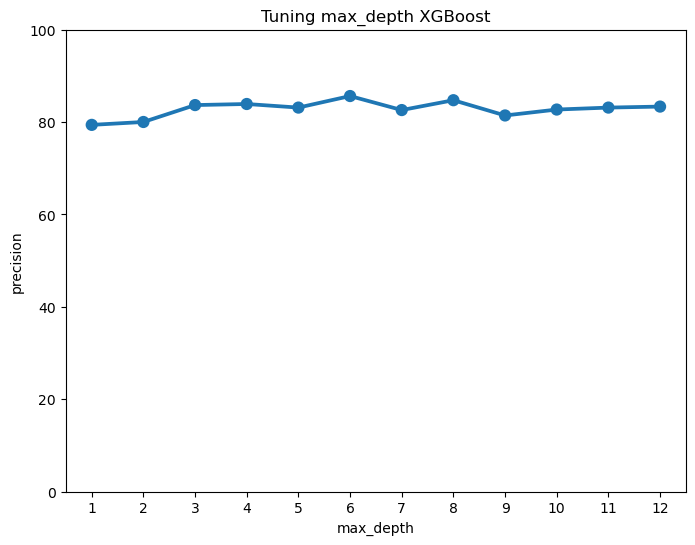

In [72]:
max_depth = []
precision = []

for depth in range(1,13):
  xgb = XGBClassifier(eta=0.4, max_depth=depth,random_state=42).fit(X_train,y_train)
  prec = precision_score(y_test,xgb.predict(X_test))*100
  precision.append(prec)
  max_depth.append(depth)


#create dataset eta
df_max_depth = pd.DataFrame({'max_depth':max_depth,
                       'precision':precision})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_max_depth,x='max_depth',y='precision')
plt.title('Tuning max_depth XGBoost')
plt.ylim(0,100)
plt.show()

The best max_depth is 6

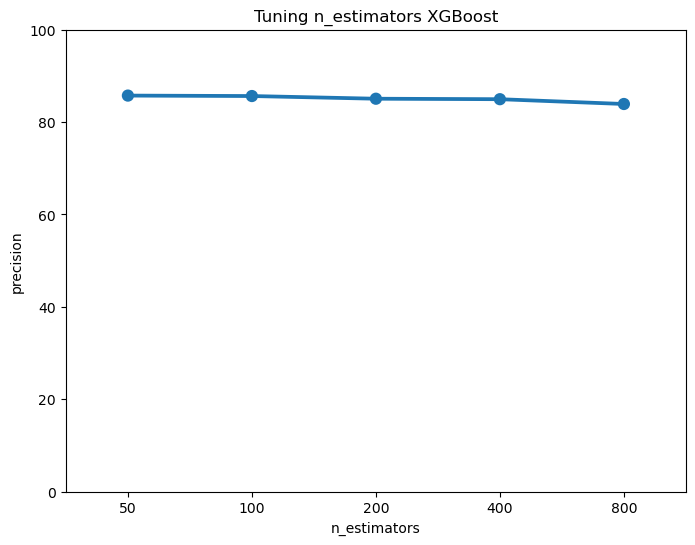

In [74]:
n_estimators = []
precision = []

for estimator in [50, 100, 200, 400, 800]:
  xgb = XGBClassifier(eta=0.4, max_depth=6, n_estimators=estimator).fit(X_train,y_train)
  prec = precision_score(y_test,xgb.predict(X_test))*100
  precision.append(prec)
  n_estimators.append(estimator)


#create dataset eta
df_estimator = pd.DataFrame({'n_estimators':n_estimators,
                       'precision':precision})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_estimator,x='n_estimators',y='precision')
plt.title('Tuning n_estimators XGBoost')
plt.ylim(0,100)
plt.show()

The best amount of tree is 50

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


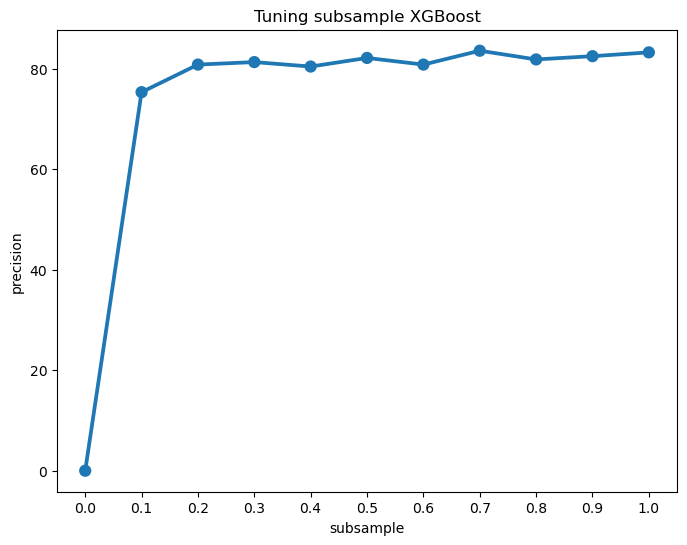

In [76]:
subsample = []
precision = []

for sub in [0,0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1]:
  xgb = XGBClassifier(eta=0.3, max_depth=6, n_estimators=50, subsample=sub,random_state=42).fit(X_train,y_train)
  prec = precision_score(y_test,xgb.predict(X_test))*100
  precision.append(prec)
  subsample.append(sub)


#create dataset eta
df_subsample = pd.DataFrame({'subsample':subsample,
                       'precision':precision})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_subsample,x='subsample',y='precision')
plt.title('Tuning subsample XGBoost')
plt.show()

The best subsample is 0.7

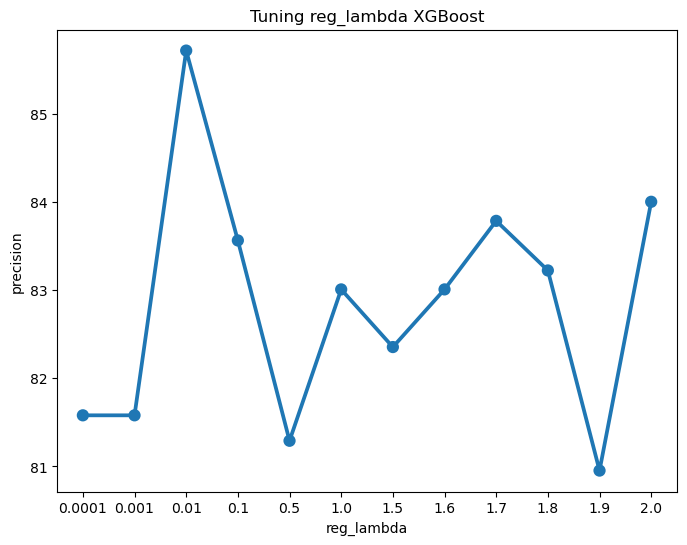

In [78]:
reg_lambda = []
precision = []

for lambda_ in [0.0001,0.001, 0.01, 0.1, 0.5, 1, 1.5,1.6,1.7,1.8,1.9,2]:
  xgb = XGBClassifier(eta=0.4, max_depth=6, n_estimators=50, subsample=0.7, reg_lambda=lambda_,random_state=42).fit(X_train,y_train)
  prec = precision_score(y_test,xgb.predict(X_test))*100
  precision.append(prec)
  reg_lambda.append(lambda_)


#create dataset eta
df_reg_lambda = pd.DataFrame({'reg_lambda':reg_lambda,
                       'precision':precision})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_reg_lambda,x='reg_lambda',y='precision')
plt.title('Tuning reg_lambda XGBoost')
plt.show()

The best reg_lambda is 0.01

Hyperparameter untuk dataset ini adalah eta=0.4, max_depth=6, n_estimators=50, subsample=0.7, reg_lambda= 0.01

In [90]:
list_model1 = [XGBClassifier(random_state=42),
              XGBClassifier(eta=0.4, max_depth=6, n_estimators=50, subsample=0.7, reg_lambda= 0.01, random_state=42)
]

df_eval2 = pd.DataFrame(columns = ['methods','precison train', 'precision test'])

for model in list_model1:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    method1 = str(type(model)).split('.')[-1][:-2]
    
    #recall
    prec_train = precision_score(y_train, y_pred_train)
    prec_test = precision_score(y_test, y_pred_test)
    
    df_eval2 = df_eval2.append({'methods': method1, 'precison train':prec_train, 'precision test':prec_test}, ignore_index=True)
    
df_eval2['status'] = ['Before Tuning Parameter', 'After Tuning Parameter']
df_eval2

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1404\2338618734.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_eval2 = df_eval2.append({'methods': method1, 'precison train':prec_train, 'precision test':prec_test}, ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1404\2338618734.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_eval2 = df_eval2.append({'methods': method1, 'precison train':prec_train, 'precision test':prec_test}, ignore_index=True)


,methods,precison train,precision test,status
0,XGBClassifier,1.0,0.855263,Before Tuning Parameter
1,XGBClassifier,1.0,0.857143,After Tuning Parameter


Setelah tuning parameter presisi pada test data mengalami kenaikan sebesar 0.2%, hal tersebut menunjukkan bahwa dataset ini mampu bekerja dengan baik pada kondisi parameter default XGBoost

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


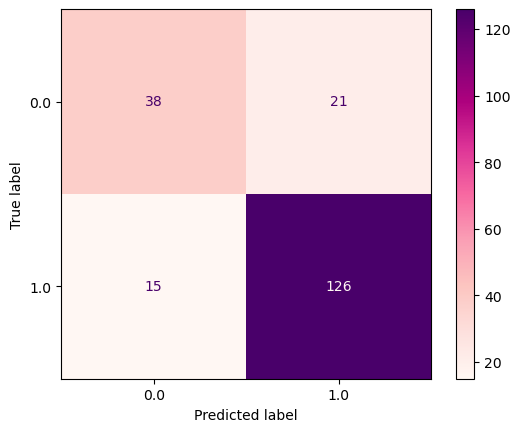

Prescision score:  0.8571428571428571


In [91]:
# plotting confusion matrix
from sklearn.metrics import plot_confusion_matrix

# instantiating and fitting decision tree model
xgb_clf = XGBClassifier(eta=0.4, max_depth=6, n_estimators=50, subsample=0.7, reg_lambda= 0.01,random_state=42) 
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

plot_confusion_matrix(xgb_clf, X_test, y_test,cmap="RdPu")
plt.show()
print('Prescision score: ',precision_score(y_test, y_pred))

**0 : Bad** 
**1 : Good**

Observation 

* 38 -> 38 with true label Bad, predicted Bad = (True Negative)
* 21 -> 21 with true label Bad, predicted Good = (False Positive)
* 15 -> 15 with true labels Good, predicted Bad = (False Negative)
* 126 -> 126 with true label Good, predicted Good = (True Positive)

* Dalam kasus ini saya ingin False positif serendah mungkin karena saya tidak ingin model membuat prediksi salah untuk pelanggan yang status credit risk nya bad

* Dengan nilain presisi 85.71% model ini bisa dikatakan cukup bagus untuk memprediksi credit risk
* Nilai presisi tersebut berarti bahwa dari 100 pelanggan yang diprediksi credit risknya good, 86 diantaranya actual credit scorenya good


**Recomendasi**
- Model machine learning mampu memprediksi status credit risk dari pelanggan menggunakan data credit dengan cukup baik, saya merekomendasikan agar bank menerapkan machine learning untuk menentukan status credit risk. hal itu dapat mempersingkat evalusi pelanggan dan bank dapat lebih mengurangi potensi credit yang berisiko buruk agar flow bisnis dapat berjalan dengan baik
- Dengan menerapkan Model machine learning pihak bank mampu memangkas Man Power dalam evaluasi status kredit pelanggan
- Model machine learning mempunyai kesalahan 15% maka perlu dilakukan double checking hasil prediksi